In [1]:
import matplotlib.pyplot as plt
import time
from gengraph import EpsimGraph
from epsim import Epsim

In [2]:
sim_iters = 150
k = 100000
office_sigmas = [0.5, 0.25, 0.125]
stage1_prob = 0.3
stage2_probs = [0.14, 0.12, 0.1, 0.08]
immunize_probs = [0.0, 0.25, 1/3, 0.5]

results = {}
for office_sigma in office_sigmas:
    results[office_sigma] = {}
    for immunize_prob in immunize_probs:
        results[office_sigma][immunize_prob] = {}

starttime = time.time()
for office_sigma in office_sigmas:
    epsim_graph = EpsimGraph(k, office_sigma)
    sim = Epsim()
    sim.init_clusters(epsim_graph.cluster_nbrs, epsim_graph.grid_nbrs, epsim_graph.b_cluster_nbrs)
    for stage2_prob in stage2_probs:
        for immunize_prob in immunize_probs:
            x_rounds, y_num_infected = sim.run_sim(sim_iters, stage1_prob, stage2_prob, immunize_prob)
            results[office_sigma][immunize_prob][stage2_prob] = (x_rounds, y_num_infected)
print('runtime: {}s'.format(time.time() - starttime))

creating graph with k=100000, sigma=0.5
randomly cluster nodes of a and b, such that there are a,b pairs
b: 1/2 no change, 1/4 merge 2 nodes, 1/8 merge 3 nodes, ...
b: duplicate every node
a: k/l^2 many l*l grids, place l^2 nodes randomly on grid, cluster 8 neighbourhood, with l=5
b: cluster 1-sigma no change, sigma*1/2 cluster 2 nodes, sigma*1/4 cluster 3 nodes, sigma*1/8 cluster 4 nodes, sigma*1/8 cluster 5 nodes
starting simulation with n=238640, num_start_nodes=24, sim_iters=150, stage1_prob=0.3, stage2_prob=0.14, immunize_prob=0.0
infected nodes: 175771

starting simulation with n=238640, num_start_nodes=24, sim_iters=150, stage1_prob=0.3, stage2_prob=0.14, immunize_prob=0.25
infected nodes: 169542

starting simulation with n=238640, num_start_nodes=24, sim_iters=150, stage1_prob=0.3, stage2_prob=0.14, immunize_prob=0.3333333333333333
infected nodes: 165369

starting simulation with n=238640, num_start_nodes=24, sim_iters=150, stage1_prob=0.3, stage2_prob=0.14, immunize_prob=0.5
i

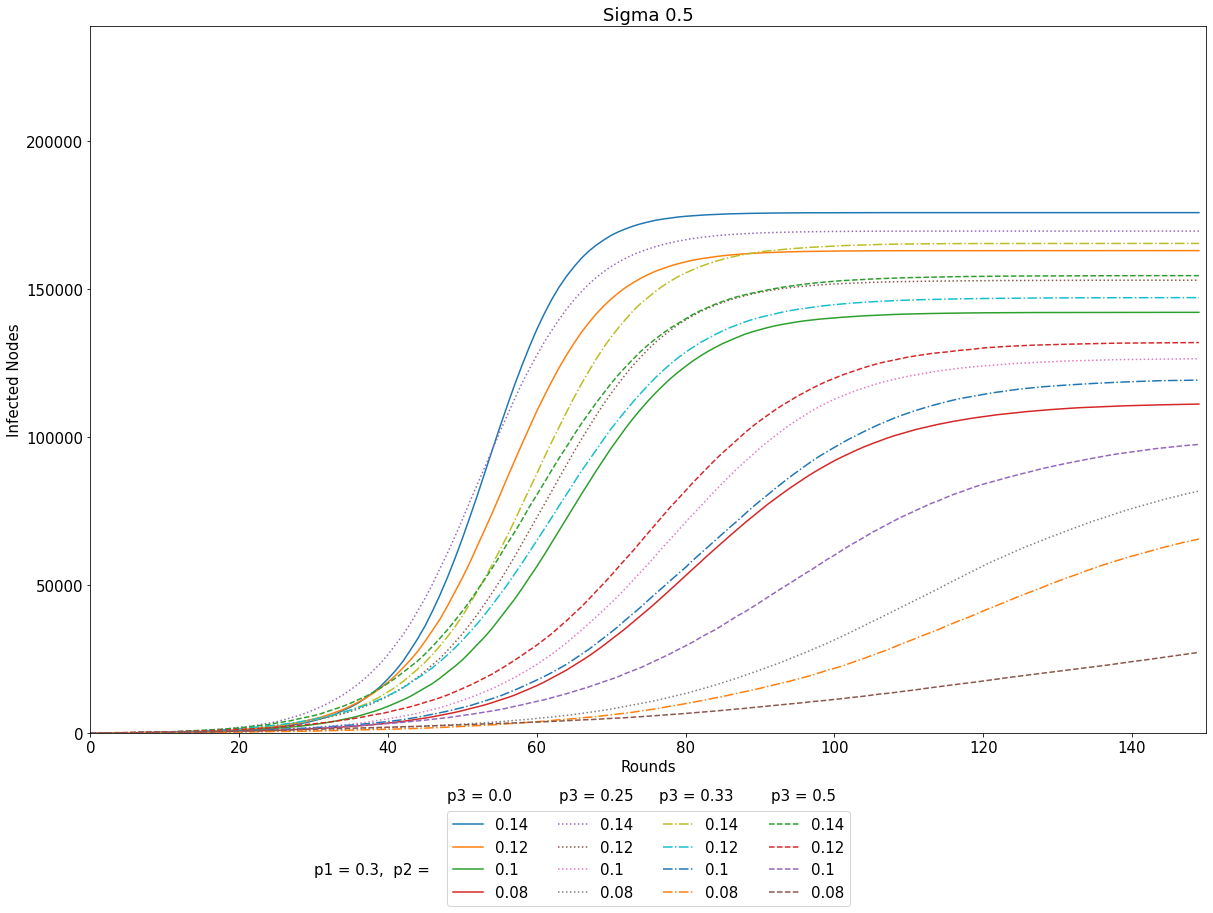

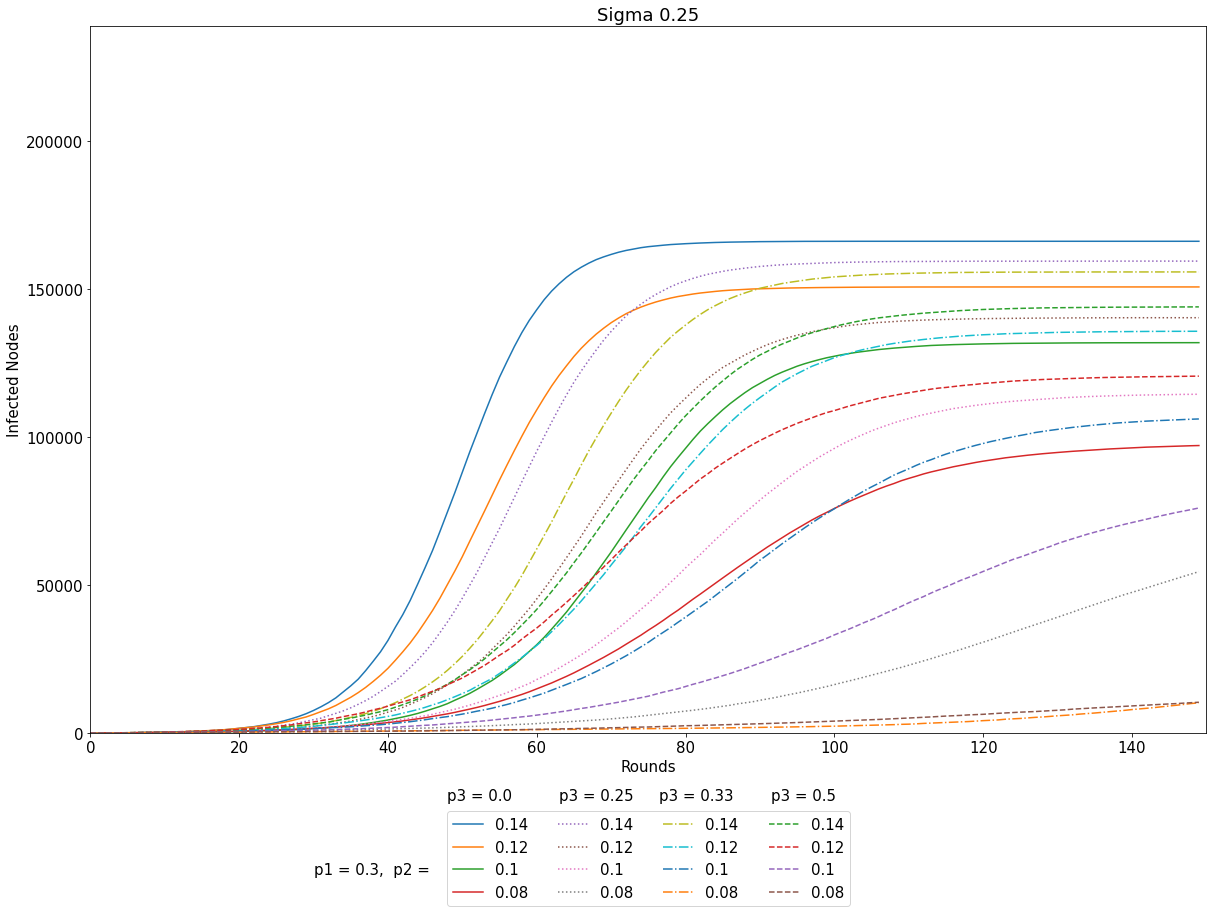

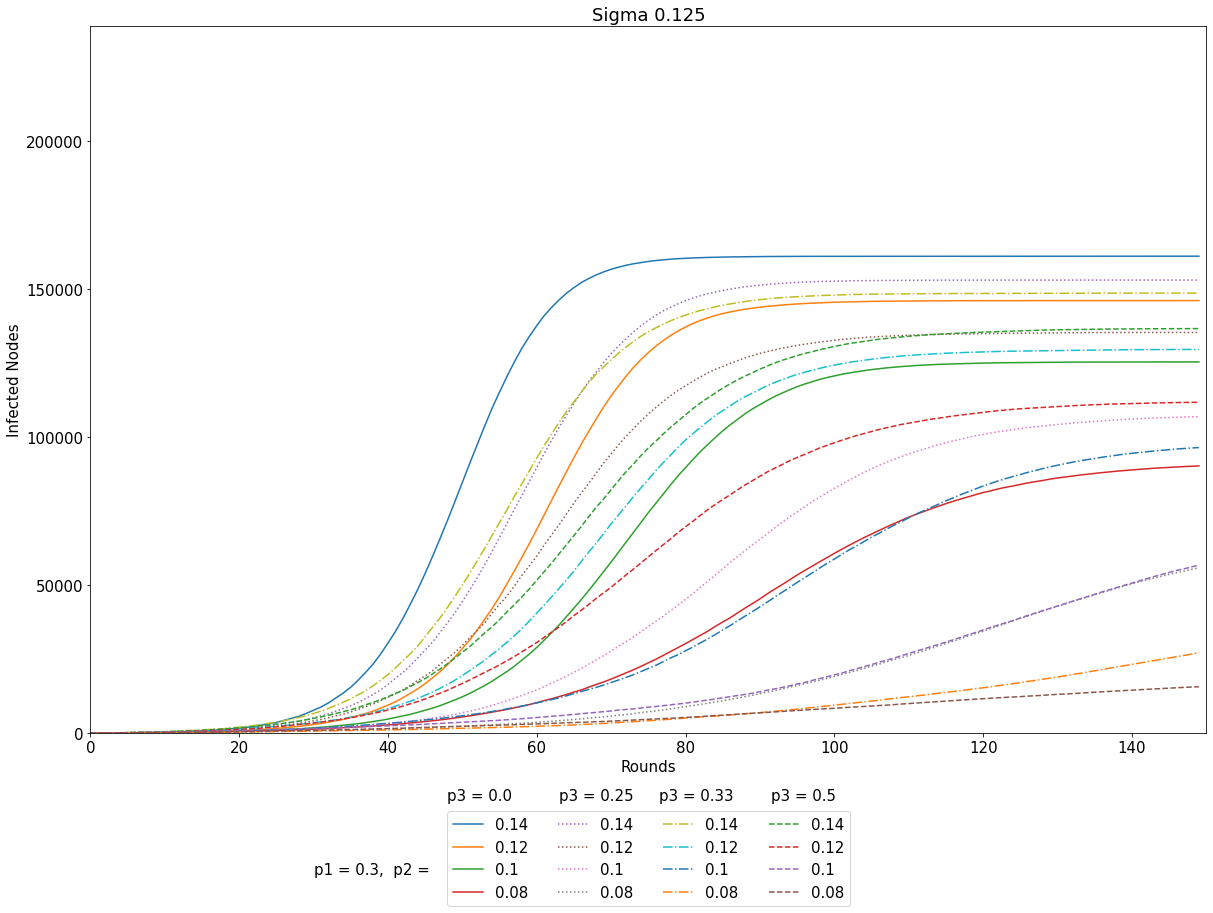

In [7]:
plt.rcParams.update({'font.size': 15})
linestyles = ['solid', 'dotted', 'dashdot', 'dashed']

for office_sigma in office_sigmas:
    fig, axs = plt.subplots(figsize=(20,13))
    axs.set_ylim(top=238640)
    axs.set_xlim(0, 150)
    for i, immunize_prob in enumerate(immunize_probs):
        for stage2_prob in stage2_probs:
            axs.plot(results[office_sigma][immunize_prob][stage2_prob][0], results[office_sigma][immunize_prob][stage2_prob][1], label=stage2_prob, linestyle=linestyles[i % len(linestyles)])
    axs.set_title('Office Sigma {}'.format(office_sigma))
    axs.set_xlabel('Rounds')
    axs.set_ylabel('Infected Nodes')
    axs.text(0.2, -0.2, 'p1 = {},  p2 ='.format(stage1_prob), transform=axs.transAxes)
    axs.text(0.32, -0.095, 'p3 = {}'.format(immunize_probs[0]), transform=axs.transAxes)
    axs.text(0.42, -0.095, 'p3 = {}'.format(immunize_probs[1]), transform=axs.transAxes)
    axs.text(0.51, -0.095, 'p3 = {:.2f}'.format(immunize_probs[2]), transform=axs.transAxes)
    axs.text(0.61, -0.095, 'p3 = {}'.format(immunize_probs[3]), transform=axs.transAxes)
    axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)